---

This notebook contains code to re-create **Figure 5** from:

*Gaussian Process Modeling to Recover Faraday Depth Spectra*, 2020, Simon W. Ndiritu, Anna M. M. Scaife, David L. Tabb, Miguel Carcamo & Joe Hanson

**Note:** The flagging and noise realisations implemented in this notebook are stochastic, so the figure will have the same properties as the one that appears in the paper but is unlikely to be identical.

---

In [1]:
import numpy as np
import pylab as pl
import itertools

In [2]:
from celerite_base import *
from faraday_stuff import *

In [3]:
pl.rcParams['figure.figsize'] = [10, 5]
pl.rcParams['figure.dpi'] = 300

---

Set random seed for reproducibility:

In [4]:
np.random.seed(42) # the meaning of life, the universe and everything

---
### Create data

In [5]:
def make_scenario2(phi_fg, phi_gal, l2):
    
    p_fg = 1.0
    p_gal = 0.25
    mu_q = p_fg*np.sin(2*phi_fg*l2)/(2.*phi_fg*l2) + p_gal*np.cos(2.*phi_gal*l2)
    mu_u = p_gal*np.sin(2.*phi_gal*l2)
    
    return mu_q, mu_u

In [6]:
const_c = 3e8    # speed of light

nu_min = 0.58e9  # minimum frequency
nu_max = 2.50e9  # maximum frequency

nchan = 512

nu = np.linspace(nu_min, nu_max, nchan)  # make data regularly spaced in frequency:
l2 = (const_c/nu)**2                   # convert frequencies to lambda^2

In [7]:
phi_fg = 10.
phi_gal = 50.
stokesQ, stokesU = make_scenario2(phi_fg, phi_gal, l2)

In [8]:
l2_ref = (const_c/1.4e9)**2
q0, u0 = make_scenario2(phi_fg, phi_gal, l2_ref)
p0 = np.sqrt(q0**2 + u0**2)

In [9]:
snr_chan = 5
noise = p0/snr_chan
stokesQn=stokesQ + np.random.normal(loc =0.0, scale=noise, size = len(stokesQ))
stokesUn=stokesU + np.random.normal(loc =0.0, scale=noise, size = len(stokesU))

In [10]:
snr_int = np.sqrt(nchan)*p0/noise
print("SNR_chan: ",p0/noise)
print("SNR_int [no flagging]: ",snr_int)
print("SNR_int [20% flagging]: ",np.sqrt(0.8*nchan)*p0/noise)
print("SNR_int [30% flagging]: ",np.sqrt(0.7*nchan)*p0/noise)
print("SNR_int [40% flagging]: ",np.sqrt(0.6*nchan)*p0/noise)

('SNR_chan: ', 5.0)
('SNR_int [no flagging]: ', 113.13708498984761)
('SNR_int [20% flagging]: ', 101.19288512538814)
('SNR_int [30% flagging]: ', 94.65727652959386)
('SNR_int [40% flagging]: ', 87.63560920082658)


---
### Extract flagged data sets

In [11]:
def flag_chans(remove_frac,nu):
    _chansremoved = []
    while True:
        pos = np.random.randint(0,len(nu))  # get position
        width = np.random.uniform(0,100)  # get chunk size
        low = int(pos - 0.5*width)
        if low<0: low = 0
        high= int(pos + 0.5*width)
        if high>=len(nu): high = len(nu)-1

        _chansremoved.append(list(np.arange(low,high)))
        merged = list(itertools.chain(*_chansremoved))

        chans_removed = np.unique(np.ravel(np.array(merged)))
        frac = float(len(chans_removed))/float(len(nu))
        if frac > remove_frac: break
        
    # adjust back towards specified fraction
    # using single channel adjustments:
    while True:
        idx = np.random.randint(0,len(chans_removed))
        chans_removed = np.delete(chans_removed, idx)
        frac = float(len(chans_removed))/float(len(nu))
        if frac<=remove_frac: break
   
    print("Fraction removed: ",frac)
    mask = np.zeros(len(nu), dtype=bool)
    mask[chans_removed] = 1

    return mask

In [12]:
remove_frac = 0.2
mask20 = flag_chans(remove_frac,nu)

nu20      = nu[~mask20]
l2_20     = l2[~mask20]
stokesQ20n = stokesQn[~mask20]
stokesU20n = stokesUn[~mask20]

('Fraction removed: ', 0.19921875)


In [13]:
remove_frac = 0.3
mask30 = flag_chans(remove_frac,nu)

nu30      = nu[~mask30]
l2_30     = l2[~mask30]
stokesQ30n = stokesQn[~mask30]
stokesU30n = stokesUn[~mask30]

('Fraction removed: ', 0.298828125)


In [14]:
remove_frac = 0.4
mask40 = flag_chans(remove_frac,nu)

nu40      = nu[~mask40]
l2_40     = l2[~mask40]
stokesQ40n = stokesQn[~mask40]
stokesU40n = stokesUn[~mask40]

('Fraction removed: ', 0.3984375)


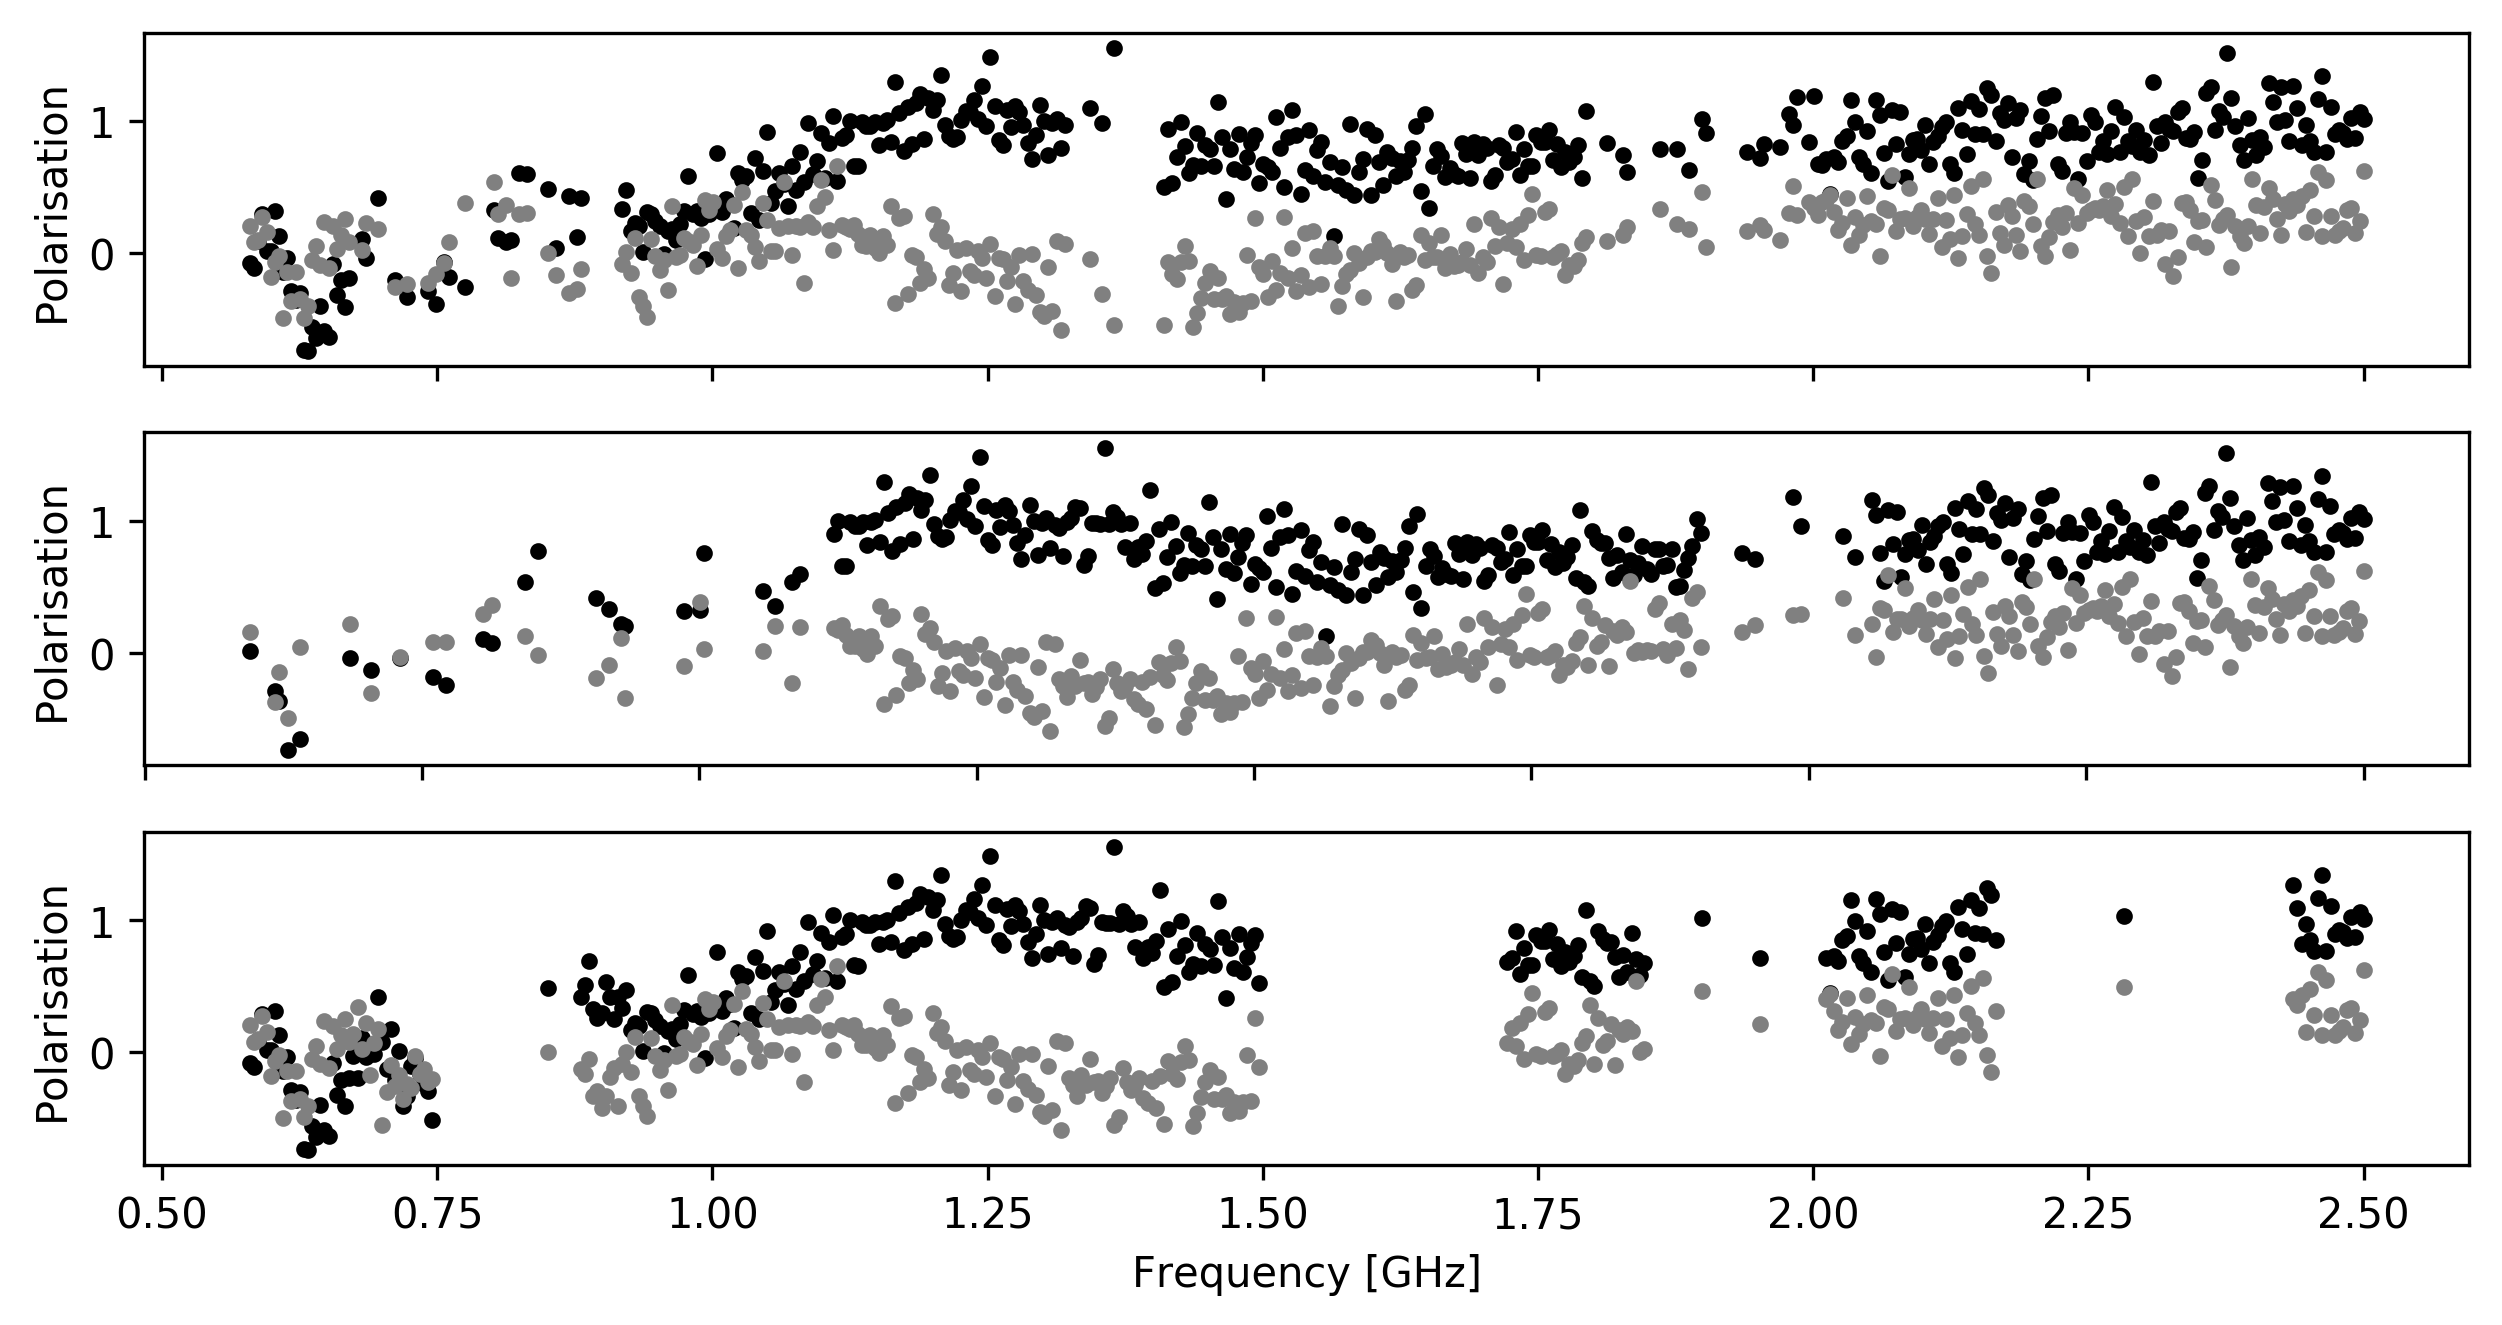

In [15]:
ax1 = pl.subplot(311)

ax1.errorbar(nu20/1e9, stokesQ20n, yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax1.errorbar(nu20/1e9, stokesU20n, yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax1.set_ylabel("Polarisation")
ax1.tick_params(labelbottom=False)    

ax2 = pl.subplot(312)

ax2.errorbar(nu30/1e9, stokesQ30n, yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax2.errorbar(nu30/1e9, stokesU30n, yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax2.set_ylabel("Polarisation")
ax2.tick_params(labelbottom=False)    

ax3 = pl.subplot(313)

ax3.errorbar(nu40/1e9, stokesQ40n, yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax3.errorbar(nu40/1e9, stokesU40n, yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax3.set_ylabel("Polarisation")
ax3.set_xlabel("Frequency [GHz]")

pl.show()

---
### Make predictions

Predict QU data at regular intervals in $\lambda^2$:

In [16]:
lstar = np.linspace(np.min(l2_20), np.max(l2_20), 512)

In [17]:
GP = MyCelerite(noise)
GP.celerite_optimize(l2_20, stokesQ20n, stokesU20n)
mu_q20, std_q20, mu_u20, std_u20 = GP.celerite_predict(stokesQ20n, stokesU20n, lstar)

In [18]:
GP = MyCelerite(noise)
GP.celerite_optimize(l2_30, stokesQ30n, stokesU30n)
mu_q30, std_q30, mu_u30, std_u30 = GP.celerite_predict(stokesQ30n, stokesU30n, lstar)

In [19]:
GP = MyCelerite(noise)
GP.celerite_optimize(l2_40, stokesQ40n, stokesU40n)
mu_q40, std_q40, mu_u40, std_u40 = GP.celerite_predict(stokesQ40n, stokesU40n, lstar)

---
### Create Faraday depth spectra

In [20]:
fspec20 = []; rmtf20 = []
fspec30 = []; rmtf30 = []
fspec40 = []; rmtf40 = []

w20 = np.ones(len(stokesQ20n))
w30 = np.ones(len(stokesQ30n))
w40 = np.ones(len(stokesQ40n))

phi = np.linspace(-500,500,10000)

for i in range(0,len(phi)):
    fspec20.append(calc_f(phi[i],l2_20[::-1],stokesQ20n[::-1],stokesU20n[::-1],w20))
    rmtf20.append(calc_r(phi[i],l2_20[::-1],w20))
    fspec30.append(calc_f(phi[i],l2_30[::-1],stokesQ30n[::-1],stokesU30n[::-1],w30))
    rmtf30.append(calc_r(phi[i],l2_30[::-1],w30))
    fspec40.append(calc_f(phi[i],l2_40[::-1],stokesQ40n[::-1],stokesU40n[::-1],w40))
    rmtf40.append(calc_r(phi[i],l2_40[::-1],w40))
    
fspec20 = np.array(fspec20)
rmtf20 = np.array(rmtf20)
fspec30 = np.array(fspec30)
rmtf30 = np.array(rmtf30)
fspec40 = np.array(fspec40)
rmtf40 = np.array(rmtf40)

In [21]:
fspec20gp = []; rmtf20gp = []
fspec30gp = []; rmtf30gp = []
fspec40gp = []; rmtf40gp = []

var20gp = std_q20**2 + np.ones(len(std_q20))
w20gp = 1./var20gp
var30gp = std_q30**2 + np.ones(len(std_q30))
w30gp = 1./var30gp
var40gp = std_q40**2 + np.ones(len(std_q40))
w40gp = 1./var40gp

phi = np.linspace(-500,500,10000)

for i in range(0,len(phi)):
    fspec20gp.append(calc_f(phi[i],lstar,mu_q20,mu_u20,w20gp))
    rmtf20gp.append(calc_r(phi[i],lstar,w20gp))
    fspec30gp.append(calc_f(phi[i],lstar,mu_q30,mu_u30,w30gp))
    rmtf30gp.append(calc_r(phi[i],lstar,w30gp))
    fspec40gp.append(calc_f(phi[i],lstar,mu_q40,mu_u40,w40gp))
    rmtf40gp.append(calc_r(phi[i],lstar,w40gp))
    
fspec20gp = np.array(fspec20gp)
rmtf20gp = np.array(rmtf20gp)
fspec30gp = np.array(fspec30gp)
rmtf30gp = np.array(rmtf30gp)
fspec40gp = np.array(fspec40gp)
rmtf40gp = np.array(rmtf40gp)

Calculate the noise limits:

In [22]:
#justnoise20 = np.random.normal(loc =0.0, scale=noise, size = len(l2_20))
#justnoise30 = np.random.normal(loc =0.0, scale=noise, size = len(l2_30))
#justnoise40 = np.random.normal(loc =0.0, scale=noise, size = len(l2_40))

#nspec20gp = []; nspec30gp = []; nspec40gp = []

#for i in range(0,len(phi)):
#    nspec20gp.append(calc_f(phi[i],l2_20[::-1],justnoise20,justnoise20,w20))
#    nspec30gp.append(calc_f(phi[i],l2_30[::-1],justnoise30,justnoise30,w30))
#    nspec40gp.append(calc_f(phi[i],l2_40[::-1],justnoise40,justnoise40,w40))
    
#nspec20gp = np.array(nspec20gp)
#nspec30gp = np.array(nspec30gp)
#nspec40gp = np.array(nspec40gp)

#sigma_fd20 = 5.*np.std(np.real(nspec20gp))
#sigma_fd30 = 5.*np.std(np.real(nspec30gp))
#sigma_fd40 = 5.*np.std(np.real(nspec40gp))

In [23]:
nc_20 = 0.8*nchan
nc_30 = 0.7*nchan
nc_40 = 0.6*nchan

sigma_fd20 = 5.*noise/np.sqrt(nc_20)
sigma_fd30 = 5.*noise/np.sqrt(nc_30)
sigma_fd40 = 5.*noise/np.sqrt(nc_40)

In [24]:
print(sigma_fd20,sigma_fd30,sigma_fd40)

(0.043050183716040885, 0.046022582258028466, 0.0497100703142381)


---
Make residuals

In [25]:
modq, modu = make_scenario2(phi_fg, phi_gal, lstar)

In [26]:
res20q = modq - mu_q20
res20u = modu - mu_u20

res30q = modq - mu_q30
res30u = modu - mu_u30

res40q = modq - mu_q40
res40u = modu - mu_u40

In [27]:
fres20, fres30, fres40 = [], [] ,[]
for i in range(0,len(phi)):
    fres20.append(calc_f(phi[i],lstar,res20q,res20u,w20gp))
    fres30.append(calc_f(phi[i],lstar,res30q,res30u,w30gp))
    fres40.append(calc_f(phi[i],lstar,res40q,res40u,w40gp))
    
fres20 = np.array(fres20)
fres30 = np.array(fres30)
fres40 = np.array(fres40)

---
### Make plot

In [28]:
pl.rcParams['figure.figsize'] = [15, 20]
pl.rcParams['figure.dpi'] = 300

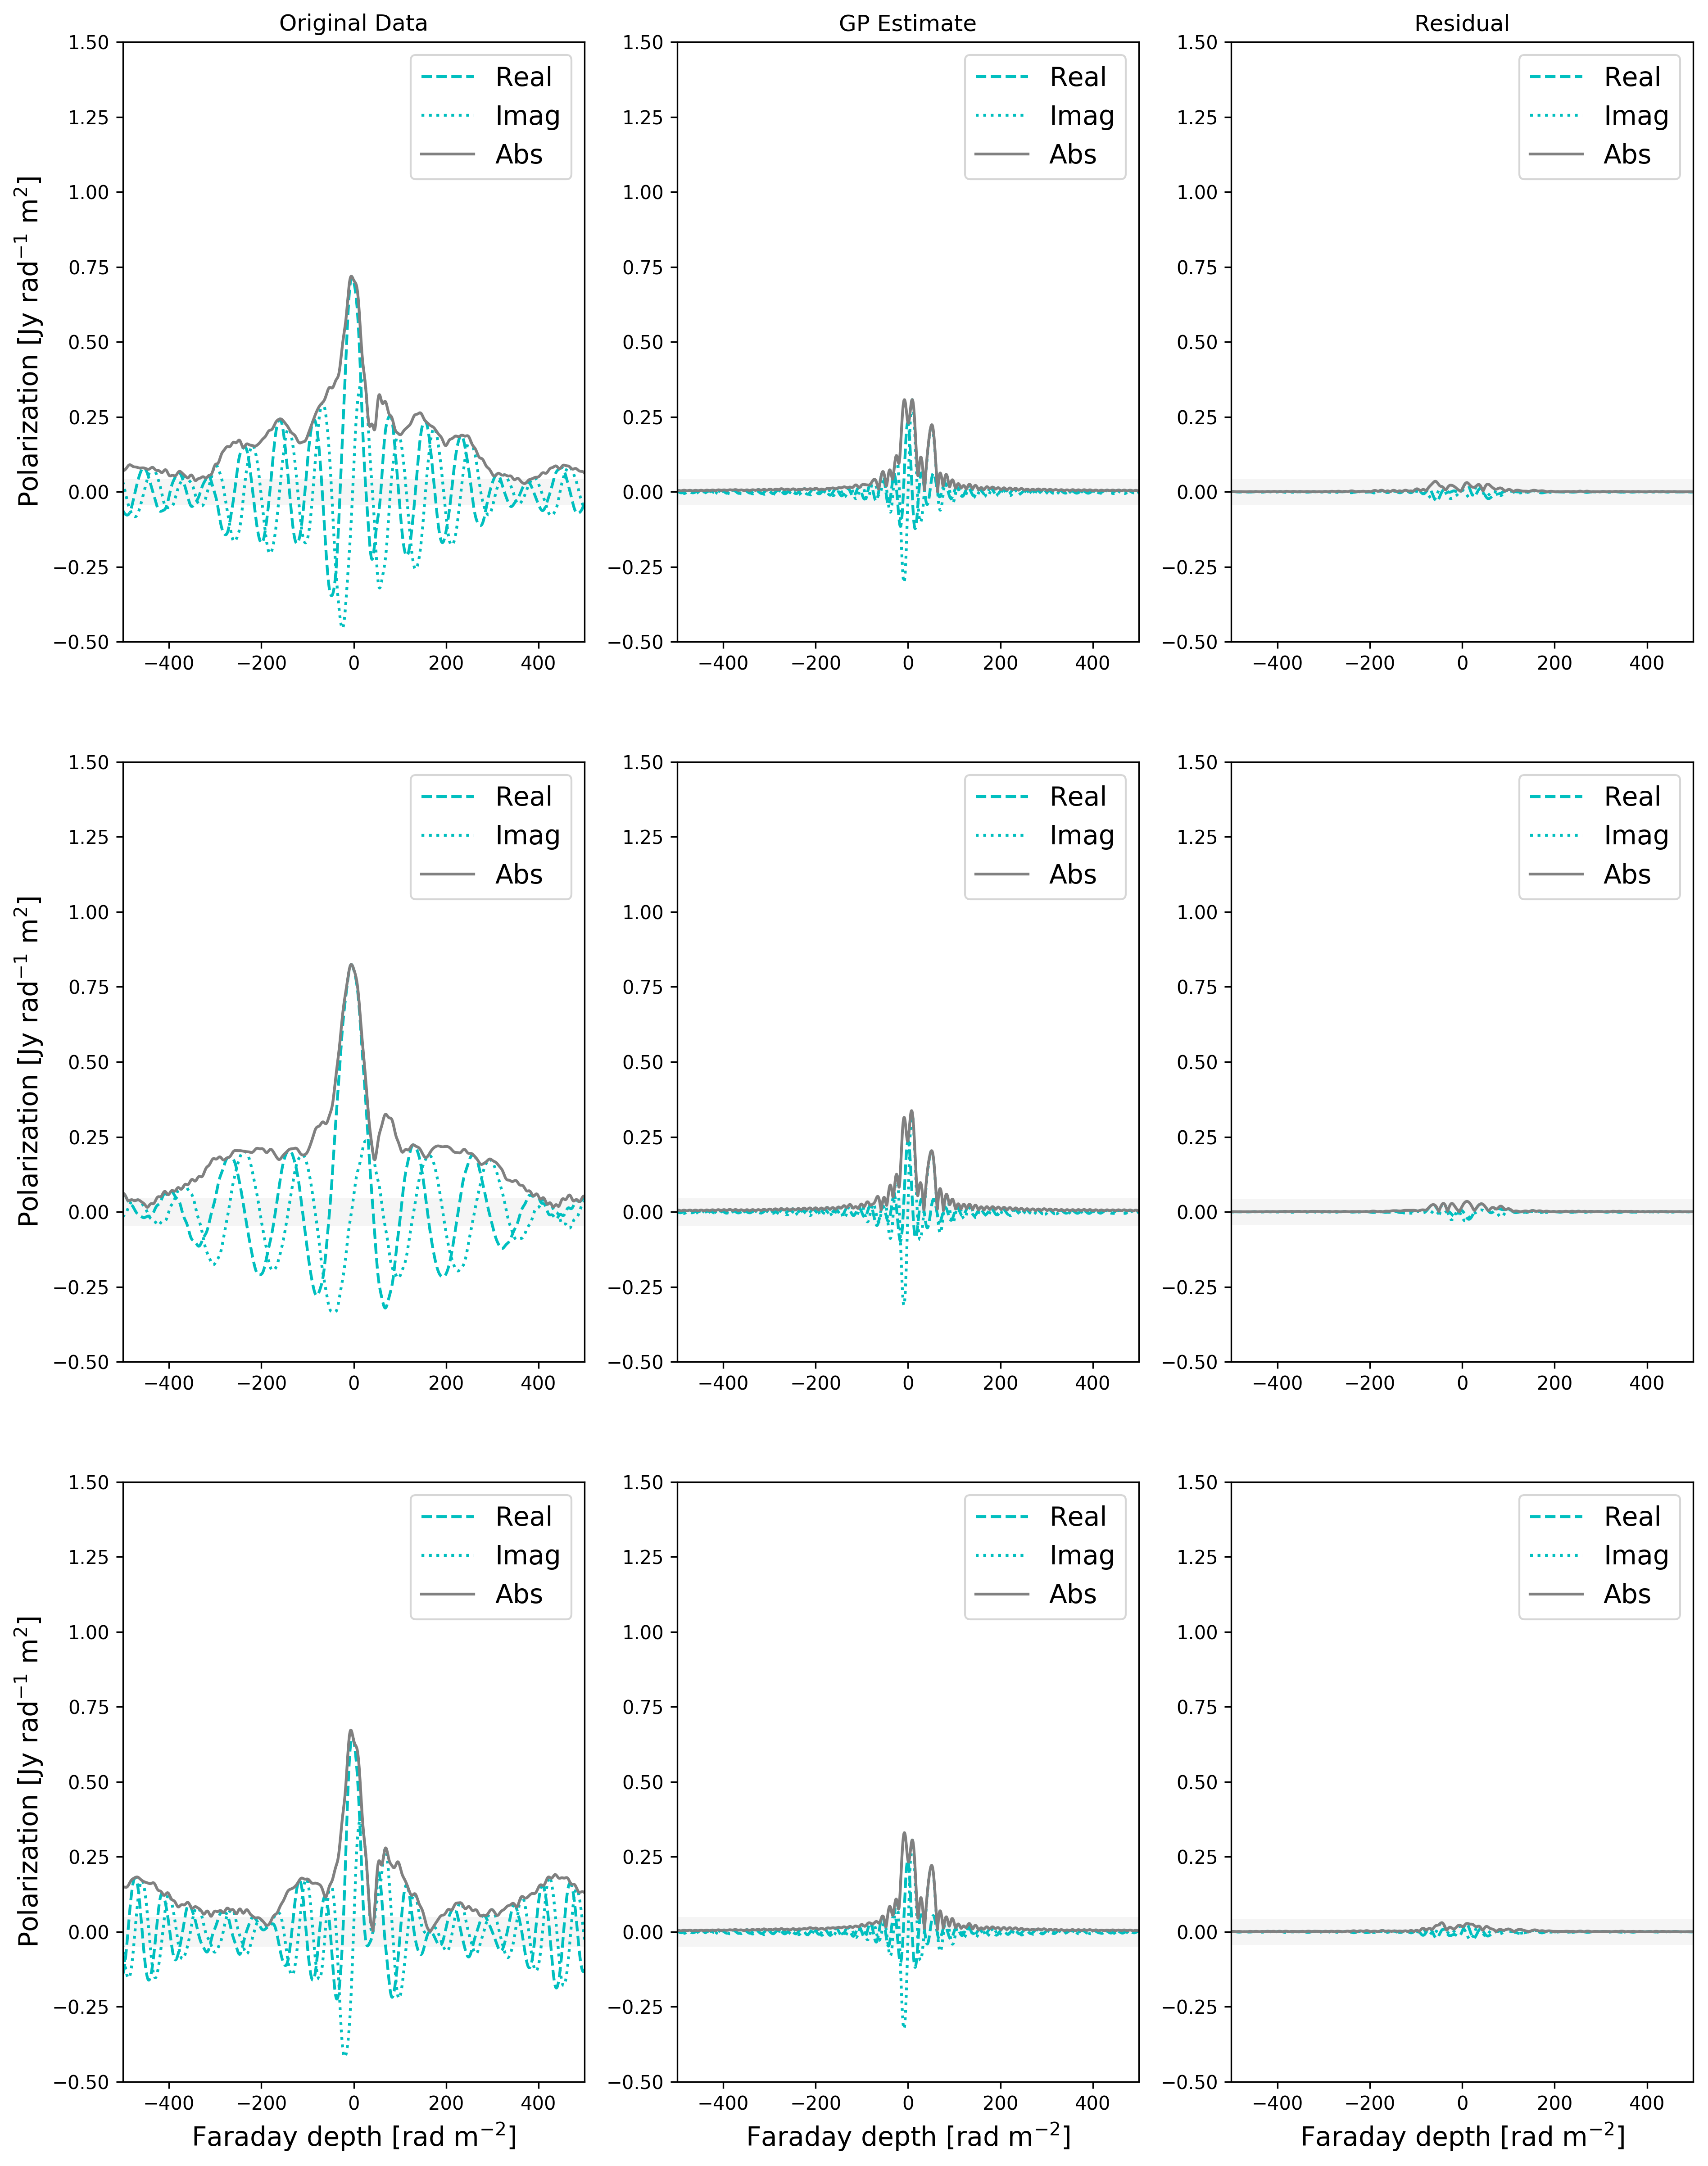

In [29]:
pl.subplot(331)
pl.title("Original Data")
pl.fill_between([-500,500],[-sigma_fd20,-sigma_fd20],[sigma_fd20,sigma_fd20], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec20),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec20),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec20),ls='-',c='grey',label="Abs")
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=14)
#pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=16)
pl.legend(fontsize=14)

pl.subplot(332)
pl.title("GP Estimate")
pl.fill_between([-500,500],[-sigma_fd20,-sigma_fd20],[sigma_fd20,sigma_fd20], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec20gp),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec20gp),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec20gp),ls='-',c='grey',label="Abs")    
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
#pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=16)
#pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=16)
pl.legend(fontsize=14)

pl.subplot(333)
pl.title("Residual")
pl.fill_between([-500,500],[-sigma_fd20,-sigma_fd20],[sigma_fd20,sigma_fd20], facecolor='whitesmoke')
pl.plot(phi,np.real(fres20),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fres20),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fres20),ls='-',c='grey',label="Abs")    
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
#pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=16)
#pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=16)
pl.legend(fontsize=14)

pl.subplot(334)
pl.fill_between([-500,500],[-sigma_fd30,-sigma_fd30],[sigma_fd30,sigma_fd30], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec30),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec30),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec30),ls='-',c='grey',label="Abs")
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=14)
#pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=16)
pl.legend(fontsize=14)

pl.subplot(335)
pl.fill_between([-500,500],[-sigma_fd30,-sigma_fd30],[sigma_fd30,sigma_fd30], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec30gp),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec30gp),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec30gp),ls='-',c='grey',label="Abs")    
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
#pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=16)
#pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=16)
pl.legend(fontsize=14)

pl.subplot(336)
pl.fill_between([-500,500],[-sigma_fd20,-sigma_fd20],[sigma_fd20,sigma_fd20], facecolor='whitesmoke')
pl.plot(phi,np.real(fres30),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fres30),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fres30),ls='-',c='grey',label="Abs")    
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
#pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=16)
#pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=16)
pl.legend(fontsize=14)

pl.subplot(337)
pl.fill_between([-500,500],[-sigma_fd40,-sigma_fd40],[sigma_fd40,sigma_fd40], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec40),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec40),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec40),ls='-',c='grey',label="Abs")
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=14)
pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=14)
pl.legend(fontsize=14)

pl.subplot(338)
pl.fill_between([-500,500],[-sigma_fd40,-sigma_fd40],[sigma_fd40,sigma_fd40], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec40gp),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec40gp),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec40gp),ls='-',c='grey',label="Abs")    
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
#pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=16)
pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=14)
pl.legend(fontsize=14)

pl.subplot(339)
pl.fill_between([-500,500],[-sigma_fd20,-sigma_fd20],[sigma_fd20,sigma_fd20], facecolor='whitesmoke')
pl.plot(phi,np.real(fres40),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fres40),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fres40),ls='-',c='grey',label="Abs")    
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
#pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]", fontsize=16)
pl.xlabel(r"Faraday depth [rad m$^{-2}$]", fontsize=14)
pl.legend(fontsize=14)


pl.show()